# CSE 291 Assignment 2 BiLSTM CRF

## Download Data/Eval Script

In [16]:
!wget https://raw.githubusercontent.com/sighsmile/conlleval/master/conlleval.py
!wget https://raw.githubusercontent.com/tberg12/cse291spr21/main/assignment2/train.data.quad
!wget https://raw.githubusercontent.com/tberg12/cse291spr21/main/assignment2/dev.data.quad

--2021-05-25 10:12:16--  https://raw.githubusercontent.com/sighsmile/conlleval/master/conlleval.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7502 (7.3K) [text/plain]
Saving to: ‘conlleval.py.1’

conlleval.py.1      100%[===================>]   7.33K  --.-KB/s    in 0s      

2021-05-25 10:12:17 (61.5 MB/s) - ‘conlleval.py.1’ saved [7502/7502]

--2021-05-25 10:12:17--  https://raw.githubusercontent.com/tberg12/cse291spr21/main/assignment2/train.data.quad
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 745734 (728K) [text/plai

In [252]:
import conlleval_own
from tqdm import tqdm
import numpy as np
from collections import defaultdict, Counter
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
from torchtext.vocab import Vocab
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import precision_recall_fscore_support
import random

SEED = 291
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [365]:
model_name = 'crf'

## Data Preparation

In [366]:
TRAIN_DATA = 'train.data.quad'
VALID_DATA = 'dev.data.quad'
UNK = '<unk>'
PAD = '<pad>'
START_TAG = "<start>"  # you can add this explicitly or use it implicitly in your CRF layer
STOP_TAG = "<stop>"    # you can add this explicitly or use it implicitly in your CRF layer


def read_conll_sentence(path):
    """ Read a CONLL-format sentence into vocab objects
    Args:
        :param path: path to CONLL-format data file
        :param word_vocab: Vocabulary object for source
        :param label_vocab: Vocabulary object for target
    """
    sent = [[], []]
    with open(path) as f:
        for line in f:
            line = line.strip().split()
            if line:
                # replace numbers with 0000
                word = line[0]
                word = '0000' if word.isnumeric() else word
                sent[0].append(word)
                sent[1].append(line[3])
            else:
                yield sent[0], sent[1]
                sent = [[], []]


def prepare_dataset(dataset, word_vocab, label_vocab):
    dataset = [
      [
        torch.tensor([word_vocab.stoi[word] for word in sent[0]], dtype=torch.long),
        torch.tensor([label_vocab.stoi[label] for label in sent[1]], dtype=torch.long),
      ]
      for sent in dataset
    ]
    return dataset


# load a list of sentences, where each word in the list is a tuple containing the word and the label
train_data = list(read_conll_sentence(TRAIN_DATA))
train_word_counter = Counter([word for sent in train_data for word in sent[0]])
train_label_counter = Counter([label for sent in train_data for label in sent[1]])
word_vocab = Vocab(train_word_counter, specials=(UNK, PAD), min_freq=2)
if(model_name == 'crf'):
  label_vocab = Vocab(train_label_counter, specials=(START_TAG, STOP_TAG), min_freq=1)
else:
  label_vocab = Vocab(train_label_counter, specials=(), min_freq=1)
train_data = prepare_dataset(train_data, word_vocab, label_vocab)
print('Train word vocab:', len(word_vocab), 'symbols.')
print('Train label vocab:', len(label_vocab), f'symbols: {list(label_vocab.stoi.keys())}')
valid_data = list(read_conll_sentence(VALID_DATA))
valid_data = prepare_dataset(valid_data, word_vocab, label_vocab)
print('Train data:', len(train_data), 'sentences.')
print('Valid data:', len(valid_data))

print(' '.join([word_vocab.itos[i.item()] for i in train_data[0][0]]))
print(' '.join([label_vocab.itos[i.item()] for i in train_data[0][1]]))

print(' '.join([word_vocab.itos[i.item()] for i in valid_data[1][0]]))
print(' '.join([label_vocab.itos[i.item()] for i in valid_data[1][1]]))

Train word vocab: 3947 symbols.
Train label vocab: 10 symbols: ['<start>', '<stop>', 'O', 'I-PER', 'I-ORG', 'I-LOC', 'I-MISC', 'B-MISC', 'B-ORG', 'B-LOC']
Train data: 3420 sentences.
Valid data: 800
Pusan 0000 0000 0000 0000 0000 0000
I-ORG O O O O O O
Earlier this month , <unk> denied a Kabul government statement that the two sides had agreed to a ceasefire in the north .
O O O O I-PER O O I-LOC O O O O O O O O O O O O O O O


In [381]:
def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()

## This function calculates the logsumexp for an entire matrix. It has been modified from the original version to
## suit my requirements in the code
def log_sum_exp(vec_mat):
    max_vector = torch.max(vec_mat, dim = 1).values
    log_exp_sum = torch.log(torch.sum(torch.exp(vec_mat - max_vector.view(-1, 1)), dim = 1))
    log_exp_sum_final = max_vector + log_exp_sum
    return log_exp_sum_final

## BISLTM Tagger

In [45]:
# Starter code implementing a BiLSTM Tagger
# which makes locally normalized, independent
# tag classifications at each time step

class BiLSTMTagger(nn.Module):
    def __init__(self, vocab_size, tag_vocab_size, embedding_dim, hidden_dim, dropout=0.3):
        super(BiLSTMTagger, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tagset_size = tag_vocab_size
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim).to(device)
        self.bilstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True, batch_first=True).to(device)
        self.tag_projection_layer = nn.Linear(hidden_dim, self.tagset_size).to(device)
        self.dropout = nn.Dropout(p=dropout)

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2).to(device),
                torch.randn(2, 1, self.hidden_dim // 2).to(device))

    def compute_lstm_emission_features(self, sentence):
        hidden = self.init_hidden()
        embeds = self.dropout(self.word_embeds(sentence))
        bilstm_out, hidden = self.bilstm(embeds, hidden)
        bilstm_out = self.dropout(bilstm_out)
        bilstm_out = bilstm_out
        bilstm_feats = self.tag_projection_layer(bilstm_out)
        return bilstm_feats

    def forward(self, sentence):
        bilstm_feats = self.compute_lstm_emission_features(sentence)
        return bilstm_feats.max(-1)[0].sum(), bilstm_feats.argmax(-1)

    def loss(self, sentence, tags):
        bilstm_feats = self.compute_lstm_emission_features(sentence)
        # transform predictions to (n_examples, n_classes) and ground truth to (n_examples)
        return torch.nn.functional.cross_entropy(
              bilstm_feats.view(-1, self.tagset_size), 
              tags.view(-1), 
              reduction='sum'
            )

## BiLSTM CRF Tagger

In [398]:
## Class BI-SLTMS CRF tagger

## This code has been referenced and inspired from https://pytorch.org/tutorials/beginner/nlp/advanced_tutorial.html
## Although, I have written the entire code myself and vectorized it on my own to speed up the processing.
## Logic at some places in the code might also be referenced from Taylor's lecture 7 on crf
class BiLSTMCRFTagger(nn.Module):
    def __init__(self, vocab_size, tag_vocab_size, embedding_dim, hidden_dim, dropout=0.3):
        super(BiLSTMCRFTagger, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tagset_size = tag_vocab_size
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim).to(device)
        self.bilstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True, batch_first=True).to(device)
        self.tag_projection_layer = nn.Linear(hidden_dim, self.tagset_size).to(device)
        self.transition_vals = nn.Parameter(torch.randn(self.tagset_size, self.tagset_size))
        self.transition_vals.data[label_vocab.stoi[START_TAG], :] = -10000.
        self.transition_vals.data[:, label_vocab.stoi[STOP_TAG]] = -10000.
        self.dropout = nn.Dropout(p=dropout)

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2).to(device),
                torch.randn(2, 1, self.hidden_dim // 2).to(device))

    def compute_lstm_emission_features(self, sentence):
        hidden = self.init_hidden() ## hideen state of the bilstm (hidden, cell) num_dir*num_layers x batchsize x hidden size
        embeds = self.dropout(self.word_embeds(sentence))
        bilstm_out, hidden = self.bilstm(embeds, hidden)
        bilstm_out = self.dropout(bilstm_out)
        bilstm_out = bilstm_out
        bilstm_feats = self.tag_projection_layer(bilstm_out)
        return bilstm_feats
    
    
    def forward_algorithm_vectorized(self, bilstm_feats):
        init_vals = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vals[0][label_vocab.stoi[START_TAG]] = 0.
        prev_tag_vars = init_vals
        for vec in bilstm_feats[0]:
            emit_score = vec.view(-1, 1)
            total_score = emit_score + self.transition_vals + prev_tag_vars
            #print(prev_tag_vars, "prev tag")
            prev_tag_vars = log_sum_exp(total_score).view(1, -1)
            #print(prev_tag_vars, "prev tag")
        final_val = prev_tag_vars + self.transition_vals[label_vocab.stoi[STOP_TAG]]
        #print(final_val.shape, prev_tag_vars[0].shape,self.transition_vals[label_vocab.stoi[STOP_TAG]].shape)
        total_score = log_sum_exp(final_val)
        return total_score
    
    def find_numerator_score(self, bilstm_feats, tags):
        score = torch.zeros(1).to(device)
        tags = tags.view(tags.shape[1])
        
        tags = torch.cat([torch.tensor([label_vocab.stoi[START_TAG]], dtype=torch.long).to(device), tags])
        #print(tags.shape)
        for i, feat in enumerate(bilstm_feats[0]):
            score = score + self.transition_vals[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transition_vals[label_vocab.stoi[STOP_TAG], tags[-1]]
        return score
        

    def loss(self, sentence, tags):
        bilstm_feats = self.compute_lstm_emission_features(sentence)
        cumulative_score = self.forward_algorithm_vectorized(bilstm_feats)
        numerator_score = self.find_numerator_score(bilstm_feats, tags)
        loss = cumulative_score - numerator_score
        #print(numerator_score, cumulative_score, loss)
        return loss
 

    def viterbi_decoding_vectorized(self, bilstm_feats):
        
        back_ptrs = []
        init_vals = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vals[0][label_vocab.stoi[START_TAG]] = 0.
        prev_tag_vars = init_vals
        
        for feat in bilstm_feats[0]:
            total_score = self.transition_vals + prev_tag_vars
            best_tag_vals, best_tag_inds = torch.max(total_score, dim = 1)
            prev_tag_vars = best_tag_vals.view(1, -1) + feat.view(1, -1)
            back_ptrs.append(best_tag_inds)
        
        final_score = prev_tag_vars + self.transition_vals[label_vocab.stoi[STOP_TAG]].view(1, -1)
        best_tag_index = argmax(final_score)
        best_tag_val = final_score[0,best_tag_index].view(1)
        best_path = [best_tag_index]
        curr_best = best_tag_index
        for ptrs  in reversed(back_ptrs):
            curr_best = ptrs[curr_best]
            best_path.append(curr_best)
            #print("Best path", best_path)
        #print(best_path, "Best Path")
        
        best_path.pop()
        best_path.reverse()
        return  best_tag_val, best_path
            
            
    def forward(self, sentence):
        bilstm_feats = self.compute_lstm_emission_features(sentence)
        best_score, best_path  = self.viterbi_decoding_vectorized(bilstm_feats)
        return best_score, best_path


In [384]:
## Dictionaries that store training loss, validation loss
## The result.txt file stores the entire log during training to be refernced later for calcualting the metrics.
training_loss_dict = []
validation_loss_dict = []
file_write = open("result.txt", 'w')

## Train / Eval loop

In [385]:
def train(model, train_data, valid_data, word_vocab, label_vocab, model_name, epochs, log_interval=25):
    losses_per_epoch = []
    #evaluate(model, valid_data, word_vocab, label_vocab)
    for epoch in range(epochs):
        print(f'--- EPOCH {epoch} ---')
        model.train()
        losses_per_epoch.append([])
        for i, (sent, tags) in enumerate(train_data):
            model.zero_grad()
            sent, tags = sent.to(device), tags.to(device)
            sent = sent.unsqueeze(0)
            tags = tags.unsqueeze(0)
            loss = model.loss(sent, tags)
            loss.backward()
            optimizer.step()

            losses_per_epoch[-1].append(loss.detach().cpu().item())
            if i > 0 and i % log_interval == 0:
                print(f'Avg loss over last {log_interval} updates: {np.mean(losses_per_epoch[-1][-log_interval:])}')

        training_loss_dict.append(np.mean(losses_per_epoch[-1]))
        evaluate(model, valid_data, word_vocab, label_vocab, model_name)
        torch.save(model.state_dict(), 'models/ner_model_finak_{}_{}.pt'.format(model_name,epoch))


def evaluate(model, dataset, word_vocab, label_vocab, model_name):
    model.eval()
    losses = []
    scores = []
    true_tags = []
    pred_tags = []
    sents = []
    for i, (sent, tags) in enumerate(dataset):
        with torch.no_grad():
            sent, tags = sent.to(device), tags.to(device)
            sent = sent.unsqueeze(0)
            tags = tags.unsqueeze(0)
            losses.append(model.loss(sent, tags).cpu().detach().item())
            score, pred_tag_seq = model(sent)
            scores.append(score.cpu().detach().numpy())
            true_tags.append([label_vocab.itos[i] for i in tags.tolist()[0]])
            if model_name == 'crf':
              pred_tags.append([label_vocab.itos[i] for i in pred_tag_seq])
            else:
              pred_tags.append([label_vocab.itos[i] for i in pred_tag_seq[0]])
            sents.append([word_vocab.itos[i] for i in sent[0]])

    print('Avg evaluation loss:', np.mean(losses))
    validation_loss_dict.append(np.mean(losses))
    print(conlleval_own.evaluate([tag for tags in true_tags for tag in tags], [tag for tags in pred_tags for tag in tags], verbose=True))
    print('\n5 random evaluation samples:')
    for i in np.random.randint(0, len(sents), size=5):
        print('SENT:', ' '.join(sents[i]))
        print('TRUE:', ' '.join(true_tags[i]))
        print('PRED:', ' '.join(pred_tags[i]))
    return sents, true_tags, pred_tags


## Training

In [162]:
# Train BiLSTM Tagger Baseline
if model_name == 'crf':
  model = BiLSTMCRFTagger(len(word_vocab), len(label_vocab), 128, 256).to(device)
else:
  model = BiLSTMTagger(len(word_vocab), len(label_vocab), 128, 256).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train(model, train_data, valid_data, word_vocab, label_vocab, model_name, epochs=30, log_interval=500)

--- EPOCH 0 ---
Avg loss over last 500 updates: 10.922907526373864
Avg loss over last 500 updates: 8.740891910552978
Avg loss over last 500 updates: 6.768220913887024
Avg loss over last 500 updates: 5.950849521756172
Avg loss over last 500 updates: 5.048518619418144
Avg loss over last 500 updates: 5.1803735965490345
Avg evaluation loss: 4.660816584825516
I am here bc
processed 11170 tokens with 1231 phrases; found: 763 phrases; correct: 464.
accuracy:  44.44%; (non-O)
accuracy:  88.90%; precision:  60.81%; recall:  37.69%; FB1:  46.54
              LOC: precision:  74.76%; recall:  43.25%; FB1:  54.80  210
             MISC: precision:  44.44%; recall:  16.67%; FB1:  24.24  72
              ORG: precision:  56.72%; recall:  37.13%; FB1:  44.88  201
              PER: precision:  57.50%; recall:  43.63%; FB1:  49.61  280
(60.81258191349934, 37.692932575142166, 46.5396188565697)

5 random evaluation samples:
SENT: Jim Brady then gave a big <unk> to the <unk> .
TRUE: I-PER I-PER O O O O O

Avg loss over last 500 updates: 1.5217311358451844
Avg loss over last 500 updates: 1.7771587922573089
Avg loss over last 500 updates: 1.4640770926475526
Avg loss over last 500 updates: 1.5765903587341308
Avg loss over last 500 updates: 1.27073810338974
Avg loss over last 500 updates: 1.5173777339458465
Avg evaluation loss: 2.666737079322338
I am here bc
processed 11170 tokens with 1231 phrases; found: 1080 phrases; correct: 817.
accuracy:  72.47%; (non-O)
accuracy:  93.86%; precision:  75.65%; recall:  66.37%; FB1:  70.71
              LOC: precision:  89.63%; recall:  73.83%; FB1:  80.97  299
             MISC: precision:  80.15%; recall:  54.69%; FB1:  65.02  131
              ORG: precision:  64.86%; recall:  58.31%; FB1:  61.41  276
              PER: precision:  70.86%; recall:  71.82%; FB1:  71.33  374
(75.64814814814815, 66.36880584890334, 70.70532237126785)

5 random evaluation samples:
SENT: <unk> Windows 0000 sales fail to meet <unk> .
TRUE: O I-MISC I-MISC O O O O O O
PRED: 

Avg loss over last 500 updates: 0.9659558396339416
Avg loss over last 500 updates: 1.0577997666597367
Avg loss over last 500 updates: 0.9794545738697052
Avg loss over last 500 updates: 0.9344487383365631
Avg loss over last 500 updates: 0.7893602849245072
Avg loss over last 500 updates: 0.95338463139534
Avg evaluation loss: 2.862163414210081
I am here bc
processed 11170 tokens with 1231 phrases; found: 1100 phrases; correct: 831.
accuracy:  73.18%; (non-O)
accuracy:  94.11%; precision:  75.55%; recall:  67.51%; FB1:  71.30
              LOC: precision:  88.33%; recall:  77.13%; FB1:  82.35  317
             MISC: precision:  77.94%; recall:  55.21%; FB1:  64.63  136
              ORG: precision:  61.20%; recall:  59.61%; FB1:  60.40  299
              PER: precision:  75.29%; recall:  71.00%; FB1:  73.08  348
(75.54545454545455, 67.50609260763608, 71.29987129987131)

5 random evaluation samples:
SENT: A South African boy is writing back to an American girl whose message in a <unk> he fo

Avg loss over last 500 updates: 0.6162887995243073
Avg loss over last 500 updates: 0.767611998796463
Avg loss over last 500 updates: 0.7594582076072693
Avg loss over last 500 updates: 0.7286020588874816
Avg loss over last 500 updates: 0.6454344547986984
Avg loss over last 500 updates: 0.7463096668720245
Avg evaluation loss: 3.329512475579977
I am here bc
processed 11170 tokens with 1231 phrases; found: 1116 phrases; correct: 860.
accuracy:  74.01%; (non-O)
accuracy:  94.48%; precision:  77.06%; recall:  69.86%; FB1:  73.29
              LOC: precision:  88.79%; recall:  78.51%; FB1:  83.33  321
             MISC: precision:  78.17%; recall:  57.81%; FB1:  66.47  142
              ORG: precision:  67.75%; recall:  60.91%; FB1:  64.15  276
              PER: precision:  73.47%; recall:  75.07%; FB1:  74.26  377
(77.06093189964157, 69.86190089358246, 73.28504473796335)

5 random evaluation samples:
SENT: JOHANNESBURG 1996-08-26
TRUE: I-LOC O
PRED: I-LOC O
SENT: <unk> takes the <unk> on a 

Avg loss over last 500 updates: 0.5034690554141998
Avg loss over last 500 updates: 0.6584479374885559
Avg loss over last 500 updates: 0.5673298053741455
Avg loss over last 500 updates: 0.5480854783058167
Avg loss over last 500 updates: 0.44632628536224367
Avg loss over last 500 updates: 0.5934395396709442
Avg evaluation loss: 3.641953550577164
I am here bc
processed 11170 tokens with 1231 phrases; found: 1208 phrases; correct: 881.
accuracy:  75.99%; (non-O)
accuracy:  94.06%; precision:  72.93%; recall:  71.57%; FB1:  72.24
              LOC: precision:  85.59%; recall:  81.82%; FB1:  83.66  347
             MISC: precision:  79.17%; recall:  59.38%; FB1:  67.86  144
              ORG: precision:  63.33%; recall:  61.89%; FB1:  62.60  300
              PER: precision:  67.15%; recall:  75.88%; FB1:  71.25  417
(72.93046357615894, 71.56783103168156, 72.24272242722428)

5 random evaluation samples:
SENT: <unk> officials said the <unk> told authorities he <unk> the <unk> in his <unk> at 

Avg loss over last 500 updates: 0.4804385347366333
Avg loss over last 500 updates: 0.6397465682029724
Avg loss over last 500 updates: 0.45741422080993654
Avg loss over last 500 updates: 0.4297875633239746
Avg loss over last 500 updates: 0.4302713652849197
Avg loss over last 500 updates: 0.47046397495269776
Avg evaluation loss: 3.839851883724332
I am here bc
processed 11170 tokens with 1231 phrases; found: 1163 phrases; correct: 869.
accuracy:  74.61%; (non-O)
accuracy:  94.15%; precision:  74.72%; recall:  70.59%; FB1:  72.60
              LOC: precision:  86.09%; recall:  81.82%; FB1:  83.90  345
             MISC: precision:  86.05%; recall:  57.81%; FB1:  69.16  129
              ORG: precision:  62.84%; recall:  60.59%; FB1:  61.69  296
              PER: precision:  69.97%; recall:  74.53%; FB1:  72.18  393
(74.72055030094583, 70.59301380991064, 72.59816207184629)

5 random evaluation samples:
SENT: <unk> <unk> <unk> ( France ) 0000
TRUE: O I-PER I-PER O I-LOC O O
PRED: I-PER I-PE

### Saving losses and plotting the loss

In [163]:
## Saving losses
import pickle
with open('loss_dict_crf.pkl','wb') as write_file:
    pickle.dump([training_loss_dict,validation_loss_dict], write_file)

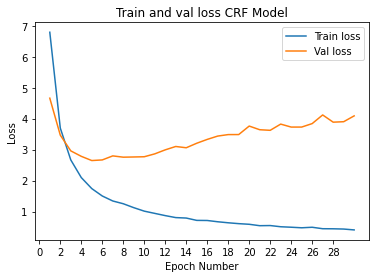

In [1]:
# Plotting the graph
import pickle
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
data = pickle.load(open('logs/loss_dict_crf.pkl','rb'))
## Plotting loss epoch  wise


epochs_to_plot = 30
train_loss = data[0][:epochs_to_plot]
valid_loss = data[1][:epochs_to_plot]
epoch_num = list(range(1,len(train_loss)+1))[:epochs_to_plot]
input_ticks = [i for i in range(30) if i%2==0]
plt.title("Train and val loss CRF Model")
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.xticks(input_ticks, input_ticks)
#plt.ylim(4,8)
plt.plot(epoch_num, train_loss, label='Train loss')
plt.plot(epoch_num, valid_loss, label='Val loss')
plt.legend()

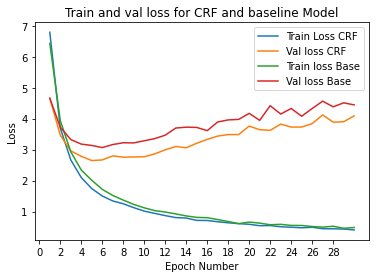

In [2]:
# Plotting the graph
import pickle
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
data = pickle.load(open('logs/loss_dict_crf.pkl','rb'))
data_base = pickle.load(open('logs/loss_dict_trad.pkl','rb'))
## Plotting loss epoch  wise


epochs_to_plot = 30
train_loss = data[0][:epochs_to_plot]
valid_loss = data[1][:epochs_to_plot]
train_loss_base = data_base[0][:epochs_to_plot]
valid_loss_base = data_base[1][:epochs_to_plot]
epoch_num = list(range(1,len(train_loss)+1))[:epochs_to_plot]
input_ticks = [i for i in range(30) if i%2==0]
plt.title("Train and val loss for CRF and baseline Model")
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.xticks(input_ticks, input_ticks)
#plt.ylim(4,8)
plt.plot(epoch_num, train_loss, label='Train Loss CRF')
plt.plot(epoch_num, valid_loss, label='Val loss CRF')
plt.plot(epoch_num, train_loss_base, label='Train loss Base')
plt.plot(epoch_num, valid_loss_base, label='Val loss Base')
plt.legend()

### Parsing the log files for precision, recall, FB1. Plotting them later

In [255]:
file_open = open('logs/result_crf.txt', 'r').readlines()
num_lines_crf = len(file_open)
precision_crf = []
recall_crf = []
f1_crf = []
non_o_acc_crf = []
total_acc_crf = []

for i in range(0, num_lines_crf, 6):
    last_line = file_open[i + 5].strip().split("\t")
    precision_crf.append(float(last_line[0]))
    recall_crf.append(float(last_line[1]))
    f1_crf.append(float(last_line[2]))
    first_line = file_open[i].strip().split("\t")
    non_o_acc_crf.append(float(first_line[4]))
    total_acc_crf.append(float(first_line[5]))
    

file_open = open('logs/result_trad.txt', 'r').readlines()
num_lines_trad = len(file_open)
precision_trad = []
recall_trad = []
f1_trad = []
non_o_acc_trad = []
total_acc_trad = []

for i in range(0, num_lines_trad, 6):
    last_line = file_open[i + 5].strip().split("\t")
    precision_trad.append(float(last_line[0]))
    recall_trad.append(float(last_line[1]))
    f1_trad.append(float(last_line[2]))
    first_line = file_open[i].strip().split("\t")
    non_o_acc_trad.append(float(first_line[4]))
    total_acc_trad.append(float(first_line[5]))

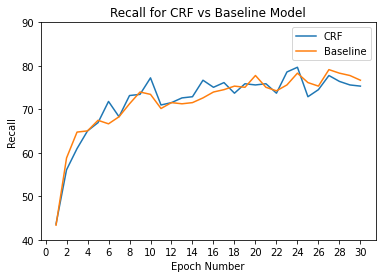

In [262]:
import matplotlib.pyplot as plt
epochs_to_plot = 30
crf_f1 = recall_crf[:epochs_to_plot]
trad_f1 = recall_trad[:epochs_to_plot]
epoch_num = list(range(1,len(crf_f1)+1))[:epochs_to_plot]
input_ticks = [i for i in range(31) if i%2==0]
plt.title("Recall for CRF vs Baseline Model")
plt.xlabel("Epoch Number")
plt.ylabel("Recall")
plt.xticks(input_ticks, input_ticks)
plt.ylim(40,90)
plt.plot(epoch_num, crf_f1, label='CRF')
plt.plot(epoch_num, trad_f1, label='Baseline')
plt.legend()

### Metrics Calculation for span and token level results

In [390]:
## Modify the evaluate function to get token levekl results as well

def evaluate_test(model, dataset, word_vocab, label_vocab, model_name):
    model.eval()
    losses = []
    scores = []
    true_tags = []
    pred_tags = []
    sents = []
    for i, (sent, tags) in enumerate(dataset):
        with torch.no_grad():
            sent, tags = sent.to(device), tags.to(device)
            sent = sent.unsqueeze(0)
            tags = tags.unsqueeze(0)
            losses.append(model.loss(sent, tags).cpu().detach().item())
            score, pred_tag_seq = model(sent)
            scores.append(score.cpu().detach().numpy())
            true_tags.append([label_vocab.itos[i] for i in tags.tolist()[0]])
            if model_name == 'crf':
              pred_tags.append([label_vocab.itos[i] for i in pred_tag_seq])
            else:
              pred_tags.append([label_vocab.itos[i] for i in pred_tag_seq[0]])
            sents.append([word_vocab.itos[i] for i in sent[0]])

    print('Avg evaluation loss:', np.mean(losses))
    labels = ['O', 'I-PER', 'I-ORG', 'I-LOC', 'I-MISC', 'B-MISC', 'B-ORG', 'B-LOC']
    labels_map = ['O', 'PER', 'ORG', 'LOC', 'MISC', 'MISC', 'ORG', 'LOC']
    final_labels = ['O', 'PER', 'ORG', 'LOC', 'MISC']
    true_seqs = [labels_map[labels.index(tag)] for tags in true_tags for tag in tags]
    pred_seqs = [labels_map[labels.index(tag)] for tags in pred_tags for tag in tags]
    token_level_prec = precision_recall_fscore_support(true_seqs, pred_seqs, average=None, labels=final_labels)
    token_level_overall = precision_recall_fscore_support(true_seqs, pred_seqs, average='macro')
    for elem in token_level_prec:
        print(elem)
    print("Final F1", token_level_overall)
    print(conlleval_own.evaluate([tag for tags in true_tags for tag in tags], [tag for tags in pred_tags for tag in tags], verbose=True))
    print('\n5 random evaluation samples:')
    for i in np.random.randint(0, len(sents), size=5):
        print('SENT:', ' '.join(sents[i]))
        print('TRUE:', ' '.join(true_tags[i]))
        print('PRED:', ' '.join(pred_tags[i]))
    return sents, true_tags, pred_tags


In [286]:
model_name = 'crf'

In [389]:

if model_name == 'crf':
    model = BiLSTMCRFTagger(len(word_vocab), len(label_vocab), 128, 256).to(device)
    model.load_state_dict(torch.load('models/ner_model_crf_14.pt', map_location=torch.device('cpu')))
else:
    model = BiLSTMTagger(len(word_vocab), len(label_vocab), 128, 256).to(device)
    model.load_state_dict(torch.load('models/ner_model_trad_29.pt', map_location=torch.device('cpu')))

In [345]:
x, y, z = evaluate_test(model, valid_data, word_vocab, label_vocab, model_name)

Avg evaluation loss: 3.193943685144186
[0.96802786 0.8189911  0.71459695 0.88511749 0.87570621]
[0.9807569  0.86520376 0.66938776 0.7995283  0.58712121]
[0.9743508  0.84146341 0.69125395 0.8401487  0.70294785]
[9354  638  490  424  264]
Final F1 (0.8524879225785025, 0.780399585262266, 0.8100329430752545, None)
processed 11170 tokens with 1231 phrases; found: 1150 phrases; correct: 870.
accuracy:  75.66%; (non-O)
accuracy:  94.43%; precision:  75.65%; recall:  70.67%; FB1:  73.08
              LOC: precision:  87.58%; recall:  79.61%; FB1:  83.41  330
             MISC: precision:  84.33%; recall:  58.85%; FB1:  69.33  134
              ORG: precision:  62.38%; recall:  61.56%; FB1:  61.97  303
              PER: precision:  72.85%; recall:  75.61%; FB1:  74.20  383
(75.65217391304347, 70.67424857839156, 73.0785384292314)

5 random evaluation samples:
SENT: " Now many Russian banks are strong and can make various <unk> of money <unk> , while <unk> traders are being ousted by more <unk> 

### Length wise analysis

In [391]:

## Makes bins based on various length sizes. Divided data into 4 categories
valid_data_binned = {}
a1 = 1
a2 = 5
a3 = 11
a4 = 21
a5 = 100
first_list = [[sent, tag] for sent, tag in valid_data if len(sent) >= a1 and len(sent) < a2]
second_list = [[sent, tag] for sent, tag in valid_data if len(sent) >= a2 and len(sent) < a3]
third_list = [[sent, tag] for sent, tag in valid_data if len(sent) >= a3 and len(sent) < a4]
fourth_list = [[sent, tag] for sent, tag in valid_data if len(sent) >= a4 and len(sent) < a5]
valid_data_binned["first"] = first_list
valid_data_binned["second"] = second_list
valid_data_binned["third"] = third_list
valid_data_binned["fourth"] = fourth_list


for key in valid_data_binned.keys():
    val_data = valid_data_binned[key]
    print("{} bin".format(key))
    print("----------------------------------------------------------------")
    print("Total {} samples".format(len(val_data)))
    x, y, z = evaluate_test(model, val_data, word_vocab, label_vocab, model_name)
    print("----------------------------------------------------------------")
    print("----------------------------------------------------------------")
    

first bin
----------------------------------------------------------------
Total 193 samples
Avg evaluation loss: 0.7624233936398758
[0.91666667 0.63636364 0.88461538 0.94871795 0.7       ]
[0.96934866 0.60869565 0.80701754 0.85057471 0.7       ]
[0.94227188 0.62222222 0.8440367  0.8969697  0.7       ]
[261  23  57  87  10]
Final F1 (0.8172727272727272, 0.7871273135362143, 0.8011000994517985, None)
processed 438 tokens with 134 phrases; found: 129 phrases; correct: 103.
accuracy:  79.66%; (non-O)
accuracy:  89.95%; precision:  79.84%; recall:  76.87%; FB1:  78.33
              LOC: precision:  86.89%; recall:  77.94%; FB1:  82.17  61
             MISC: precision:  42.86%; recall:  60.00%; FB1:  50.00  7
              ORG: precision:  85.42%; recall:  85.42%; FB1:  85.42  48
              PER: precision:  46.15%; recall:  46.15%; FB1:  46.15  13
(79.84496124031007, 76.86567164179104, 78.32699619771863)

5 random evaluation samples:
SENT: <unk> 0000 <unk> 0000
TRUE: I-ORG O I-ORG O
PRED:

### Rare words analysis

In [392]:
## Segregate the entire data into multiple bins based on of a rare word is present in that sentence
rare_word_thres = 10
word_freqs = dict(word_vocab.freqs)
rare_words = [word for word in word_freqs.keys() if (word_freqs[word]>1 and word_freqs[word]<rare_word_thres)]
rare_words_idx = [word_vocab.stoi[word] for word in rare_words]

In [393]:

valid_data_rare = []
for sent, tag in valid_data:
    word_list = sent.tolist()
    for word in word_list:
        if word in rare_words_idx:
            valid_data_rare.append([sent, tag])
            break

print("Rare Words")
print("----------------------------------------------------------------")
print("Total {} samples".format(len(valid_data_rare)))
x, y, z = evaluate_test(model, valid_data_rare, word_vocab, label_vocab, model_name)
print("----------------------------------------------------------------")
print("----------------------------------------------------------------")         

Rare Words
----------------------------------------------------------------
Total 585 samples
Avg evaluation loss: 3.8367885577373015
[0.96991371 0.81530782 0.69722222 0.89285714 0.83516484]
[0.98139001 0.87033748 0.63224181 0.7994186  0.608     ]
[0.97561811 0.8419244  0.66314399 0.84355828 0.7037037 ]
[8705  563  397  344  250]
Final F1 (0.8420931470696849, 0.7782775803589033, 0.805589697245831, None)
processed 10259 tokens with 1040 phrases; found: 976 phrases; correct: 727.
accuracy:  75.16%; (non-O)
accuracy:  94.66%; precision:  74.49%; recall:  69.90%; FB1:  72.12
              LOC: precision:  88.39%; recall:  80.00%; FB1:  83.99  267
             MISC: precision:  78.20%; recall:  57.46%; FB1:  66.24  133
              ORG: precision:  58.80%; recall:  57.81%; FB1:  58.30  233
              PER: precision:  72.89%; recall:  76.45%; FB1:  74.63  343
(74.48770491803278, 69.90384615384615, 72.12301587301586)

5 random evaluation samples:
SENT: The <unk> American <unk> off the Sta

### OOV words Analysis Token level

In [333]:
def evaluate_test(model, dataset, word_vocab, label_vocab, model_name):
    model.eval()
    losses = []
    scores = []
    true_tags = []
    pred_tags = []
    sents = []
    for i, (sent, tags) in enumerate(dataset):
        with torch.no_grad():
            sent, tags = sent.to(device), tags.to(device)
            sent = sent.unsqueeze(0)
            tags = tags.unsqueeze(0)
            losses.append(model.loss(sent, tags).cpu().detach().item())
            score, pred_tag_seq = model(sent)
            scores.append(score.cpu().detach().numpy())
            true_tags.append([label_vocab.itos[i] for i in tags.tolist()[0]])
            if model_name == 'crf':
              pred_tags.append([label_vocab.itos[i] for i in pred_tag_seq])
            else:
              pred_tags.append([label_vocab.itos[i] for i in pred_tag_seq[0]])
            sents.append([word_vocab.itos[i] for i in sent[0]])

    print('Avg evaluation loss:', np.mean(losses))
    labels = ['O', 'I-PER', 'I-ORG', 'I-LOC', 'I-MISC', 'B-MISC', 'B-ORG', 'B-LOC']
    labels_map = ['O', 'PER', 'ORG', 'LOC', 'MISC', 'MISC', 'ORG', 'LOC']
    final_labels = ['O', 'PER', 'ORG', 'LOC', 'MISC']
    true_seqs = []
    pred_seqs = []
    for word, true_tag, pred_tag in zip(sents, true_tags, pred_tags):
        #print(word)
        for word_1, true_tag_1, pred_tag_1 in zip(word, true_tag, pred_tag):
            if word_1 == "<unk>":
                true_seqs.append(labels_map[labels.index(true_tag_1)])
                pred_seqs.append(labels_map[labels.index(pred_tag_1)])

    token_level_prec = precision_recall_fscore_support(true_seqs, pred_seqs, average=None, labels=final_labels)
    token_level_overall = precision_recall_fscore_support(true_seqs, pred_seqs, average='macro')
    for elem in token_level_prec:
        print(elem)
    print("Final F1", token_level_overall)
    print(conlleval_own.evaluate([tag for tags in true_tags for tag in tags], [tag for tags in pred_tags for tag in tags], verbose=True))
    print('\n5 random evaluation samples:')
    for i in np.random.randint(0, len(sents), size=5):
        print('SENT:', ' '.join(sents[i]))
        print('TRUE:', ' '.join(true_tags[i]))
        print('PRED:', ' '.join(pred_tags[i]))
    return sents, true_tags, pred_tags


In [338]:

print("OOV words performance")
x, y, z = evaluate_test(model, train_data, word_vocab, label_vocab, model_name)
print("----------------------------------------------------------------")
print("----------------------------------------------------------------")         

OOV words performance
Avg evaluation loss: 0.146268008757586
[0.98245614 0.97487844 0.96870343 0.96753247 0.98378378]
[0.98924731 0.97251415 0.95870206 0.94006309 0.94300518]
[0.98584003 0.97369486 0.9636768  0.9536     0.96296296]
[3906 1237  678  317  193]
Final F1 (0.9754708526942457, 0.9607063593369333, 0.9679549303174797, None)
processed 46565 tokens with 5279 phrases; found: 5267 phrases; correct: 5171.
accuracy:  98.70%; (non-O)
accuracy:  99.69%; precision:  98.18%; recall:  97.95%; FB1:  98.07
              LOC: precision:  99.04%; recall:  98.54%; FB1:  98.79  1564
             MISC: precision:  99.22%; recall:  98.08%; FB1:  98.65  771
              ORG: precision:  97.57%; recall:  97.70%; FB1:  97.64  1439
              PER: precision:  97.32%; recall:  97.52%; FB1:  97.42  1493
(98.17733054869944, 97.95415798446675, 98.06561729565712)

5 random evaluation samples:
SENT: Saeed Anwar c Croft b Cork 0000
TRUE: I-PER I-PER O I-PER O I-PER O
PRED: I-PER I-PER O I-PER O I-PER O

### OOV word analysis span level

In [394]:

valid_data_oov = []
valid_data_non_oov = []
for sent, tag in valid_data:
    word_list = sent.tolist()
    if 0 in word_list:
        valid_data_oov.append([sent, tag])
    else:
        valid_data_non_oov.append([sent, tag])
        

print("OOV Words")
print("----------------------------------------------------------------")
print("Total {} samples".format(len(valid_data_oov)))
x, y, z = evaluate_test(model, valid_data_oov, word_vocab, label_vocab, model_name)
print("----------------------------------------------------------------")
print("Non-OOV Words")
print("Total {} samples".format(len(valid_data_non_oov)))
x, y, z = evaluate_test(model, valid_data_non_oov, word_vocab, label_vocab, model_name)
print("----------------------------------------------------------------")
print("----------------------------------------------------------------")         

OOV Words
----------------------------------------------------------------
Total 638 samples
Avg evaluation loss: 3.962669092005697
[0.96424946 0.81859756 0.68734491 0.86875    0.84713376]
[0.97960587 0.85645933 0.62811791 0.76164384 0.54958678]
[0.97186701 0.83710055 0.6563981  0.81167883 0.66666667]
[8728  627  441  365  242]
Final F1 (0.8372151392789222, 0.7550827445259002, 0.7887422312635501, None)
processed 10403 tokens with 1127 phrases; found: 1038 phrases; correct: 768.
accuracy:  73.13%; (non-O)
accuracy:  93.96%; precision:  73.99%; recall:  68.15%; FB1:  70.95
              LOC: precision:  86.48%; recall:  76.42%; FB1:  81.14  281
             MISC: precision:  81.51%; recall:  54.49%; FB1:  65.32  119
              ORG: precision:  59.85%; recall:  58.74%; FB1:  59.29  264
              PER: precision:  72.19%; recall:  74.59%; FB1:  73.37  374
(73.98843930635837, 68.1455190771961, 70.94688221709006)

5 random evaluation samples:
SENT: Graham Thorpe 0000 0000 0000 0000 000

### Qualitative Studies

In [367]:

if model_name == 'crf':
    model = BiLSTMCRFTagger(len(word_vocab), len(label_vocab), 128, 256).to(device)
    model.load_state_dict(torch.load('models/ner_model_crf_14.pt', map_location=torch.device('cpu')))
else:
    model = BiLSTMTagger(len(word_vocab), len(label_vocab), 128, 256).to(device)
    model.load_state_dict(torch.load('models/ner_model_trad_29.pt', map_location=torch.device('cpu')))

In [395]:
## Define an evaluate function for doing qualitative studies
def evaluate_test_sample(model, dataset, word_vocab, label_vocab, model_name):
    model.eval()
    losses = []
    scores = []
    true_tags = []
    pred_tags = []
    sents = []
    for i, (sent, tags) in enumerate(dataset):
        with torch.no_grad():
            sent, tags = sent.to(device), tags.to(device)
            sent = sent.unsqueeze(0)
            tags = tags.unsqueeze(0)
            losses.append(model.loss(sent, tags).cpu().detach().item())
            score, pred_tag_seq = model(sent)
            scores.append(score.cpu().detach().numpy())
            true_tags.append([label_vocab.itos[i] for i in tags.tolist()[0]])
            if model_name == 'crf':
              pred_tags.append([label_vocab.itos[i] for i in pred_tag_seq])
            else:
              pred_tags.append([label_vocab.itos[i] for i in pred_tag_seq[0]])
            sents.append([word_vocab.itos[i] for i in sent[0]])
    
    for i in range(len(dataset)):
        print('Avg evaluation loss:', np.mean(losses))
        print('SENT:', ' '.join(sents[i]))
        print('TRUE:', ' '.join(true_tags[i]))
        print('PRED:', ' '.join(pred_tags[i]))

In [396]:
## Code for running single samples and doing qualitative studies
evaluate_test_sample(model, valid_data[160:161], word_vocab, label_vocab, model_name)

Avg evaluation loss: 2.3061952590942383
SENT: <unk> Real Madrid <unk>
TRUE: O I-ORG I-ORG O
PRED: I-ORG I-ORG I-ORG O
